# **SECP3133 High Performance Data Processing - Section 02**
## **Assignment 2 - Mastering Big Data Handling**
### **Group LogiCode**

| Student Name | Matric No. |
|--------------|------------|
| Ong Yi Yan     | A22EC0101     |
| Tang Yan Qing          | A22EC0109        |

## Load Data
*   Downloads and extracts the Spotify Charts dataset from Kaggle using the Kaggle API



In [ ]:
# 📦 Step 1: Install Kaggle API
!pip install -q kaggle

# 🔐 Step 2: Set Kaggle credentials manually
import os

# ❗ Replace with your actual credentials
os.environ['KAGGLE_USERNAME'] = 'ongyiyana22ec0101'
os.environ['KAGGLE_KEY'] = '4bc591337dec7535200699e3efb114f1'

print("✅ Kaggle credentials set manually.")

# 📥 Step 3: Download and unzip the dataset
print("⬇️ Downloading dataset from Kaggle...")
!kaggle datasets download -d dhruvildave/spotify-charts
!unzip -q spotify-charts.zip
print("✅ Dataset downloaded and extracted.")

✅ Kaggle credentials set manually.
⬇️ Downloading dataset from Kaggle...
Dataset URL: https://www.kaggle.com/datasets/dhruvildave/spotify-charts
License(s): ODbL-1.0
 97% 917M/945M [00:08<00:00, 312MB/s]
100% 945M/945M [00:08<00:00, 115MB/s]
✅ Dataset downloaded and extracted.


## Inspect Data
*   Checks the shape of the dataset (number of rows and columns).
*   Lists the column names and their data types using `info()` and `dtypes`.


In [ ]:
import pandas as pd

# Load the dataset
df = pd.read_csv('charts.csv')

# Display the shape of the dataset
print("Shape:", df.shape)

# Display data types and non-null info
print("\nInfo:")
print(df.info())

Shape: (26173514, 9)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26173514 entries, 0 to 26173513
Data columns (total 9 columns):
 #   Column   Dtype  
---  ------   -----  
 0   title    object 
 1   rank     int64  
 2   date     object 
 3   artist   object 
 4   url      object 
 5   region   object 
 6   chart    object 
 7   trend    object 
 8   streams  float64
dtypes: float64(1), int64(1), object(7)
memory usage: 1.8+ GB
None


## Apply Big Data Handling Strategies
*   Applies big data strategies—load less data, chunking, optimize data types, sampling, and parallel processing with Dask—to efficiently handle a large dataset.



In [ ]:
important_columns = ["title", "artist", "rank", "date", "region", "chart", "streams"]
dtypes = {
    "title": "string",
    "artist": "string",
    "rank": "Int32",
    "date": "string",
    "region": "category",
    "chart": "category",
    "streams": "Int32"
}

**Pandas**
*   Loads only the needed columns in small chunks
*   Drops rows with missing data
*   Converts the date column to proper datetime format
*   Samples 10% of the data from each chunk to reduce size
*   Combines all sampled chunks into one dataset



In [ ]:
import time
import pandas as pd

start_pandas = time.time()
print("\n📚 Loading dataset...")

# Define your columns and types (assume already set earlier)
chunk_size = 100000
reader = pd.read_csv("charts.csv", usecols=important_columns, dtype=dtypes, chunksize=chunk_size)

print("✅ Dataset loaded successfully!")

chunks = []

for i, chunk in enumerate(reader):
    chunk = chunk.dropna().copy()  # Drop rows with missing values
    chunk["date"] = pd.to_datetime(chunk["date"])  # Convert date
    sampled_chunk = chunk.sample(frac=0.10, random_state=42)  # ✅ Sample 10% of the chunk
    chunks.append(sampled_chunk)

pandas_df = pd.concat(chunks, ignore_index=True)

# 🔍 Basic Dataset Info
print("\n🧾 Dataset Overview")
print(f"- Shape: {pandas_df.shape}")
print(f"- Columns: {pandas_df.columns.tolist()}")

print("\n🔠 Data Types:")
print(pandas_df.dtypes)

# Time
end_pandas = time.time()
pandas_elapsed_time = round(end_pandas - start_pandas, 2)
print(f"\n⏳ Time Taken: {pandas_elapsed_time} seconds")

# Memory
memory_used_bytes = pandas_df.memory_usage(deep=True).sum()
pandas_memory_used_mb = round(memory_used_bytes / (1024 * 1024), 2)
print(f"🧠 Memory Used: {pandas_memory_used_mb} MB")


📚 Loading dataset...
✅ Dataset loaded successfully!

🧾 Dataset Overview
- Shape: (2032190, 7)
- Columns: ['title', 'rank', 'date', 'artist', 'region', 'chart', 'streams']

🔠 Data Types:
title      string[python]
rank                Int32
date       datetime64[ns]
artist     string[python]
region             object
chart              object
streams             Int32
dtype: object

⏳ Time Taken: 133.48 seconds
🧠 Memory Used: 575.81 MB


In [ ]:
pandas_df.head()

,title,rank,date,artist,region,chart,streams
0,AMG2,71,2018-03-01,"Azzi Memo, Eno",Germany,top200,68816
1,Corazón,135,2018-03-01,"Maluma, Nego do Borel",Hungary,top200,1325
2,Steady 1234 (feat. Jasmine Thompson & Skizzy M...,50,2017-02-01,Vice,Canada,top200,42127
3,Onizuka,157,2017-01-02,PNL,Belgium,top200,2585
4,無條件,181,2017-01-04,Eason Chan,Hong Kong,top200,1948


**Dask**
*   Loads selected columns using Dask (efficient for big data)
*   Drops rows with missing values
*   Converts date column to datetime
*   Samples 10% of data randomly
*   Converts sample to Pandas DataFrame for inspection



In [ ]:
import time
import dask.dataframe as dd

start_dask = time.time()
print("\n📚 Loading dataset using Dask...")

# Load dataset with Dask
dask_df = dd.read_csv("charts.csv", usecols=important_columns, dtype=dtypes, assume_missing=True)
dask_df=dask_df.dropna()
dask_df["date"] = dd.to_datetime(dask_df["date"], errors='coerce')
print("✅ Dataset loaded and date parsed!")

# Sample 10% of the data
dask_sampled = dask_df.sample(frac=0.10, random_state=42)
dask_sampled_df = dask_sampled.compute()  # materialize into Pandas

# Overview and info (AFTER sampling)
print("\n🧾 Sampled Dataset Overview")
print(f"- Shape: {dask_sampled_df.shape}")
print(f"- Columns: {dask_sampled_df.columns.tolist()}")

print("\n🔠 Data Types:")
print(dask_sampled_df.dtypes)

# Time
end_dask = time.time()
dask_elapsed_time = round(end_dask - start_dask, 2)
print(f"\n⏳ Time Taken: {dask_elapsed_time} seconds")

# Memory
dask_mem_bytes = dask_sampled_df.memory_usage(deep=True).sum()
dask_memory_used_mb = round(dask_mem_bytes / (1024 ** 2), 2)
print(f"\n🧠 Memory Usage: {dask_memory_used_mb:.2f} MB")



📚 Loading dataset using Dask...
✅ Dataset loaded and date parsed!

🧾 Sampled Dataset Overview
- Shape: (2032187, 7)
- Columns: ['title', 'rank', 'date', 'artist', 'region', 'chart', 'streams']

🔠 Data Types:
title      string[pyarrow]
rank                 Int32
date        datetime64[ns]
artist     string[pyarrow]
region            category
chart             category
streams              Int32
dtype: object

⏳ Time Taken: 118.0 seconds

🧠 Memory Usage: 146.91 MB


In [ ]:
dask_sampled_df.head()

,title,rank,date,artist,region,chart,streams
158641,Yang Terindah,82,2018-03-03,Achey,Malaysia,top200,7063
285611,Stuck with U (with Justin Bieber),24,2020-06-01,Ariana Grande,Lithuania,top200,2501
9421,Caroline,173,2017-01-02,Aminé,Belgium,top200,2448
418040,Fresa,185,2020-05-03,"TINI, Lalo Ebratt",Peru,top200,8811
110666,Say It Again,96,2020-06-01,"ONEFOUR, A$AP Ferg",Australia,top200,43571


**Polars**
*   Loads only needed columns with Polars (fast and memory-efficient)
*   Uses lazy evaluation to optimize processing
*   Drops rows with missing values
*   Samples 10% of data by taking every 10th row
*   Collects the result into memory as a Polars DataFrame



In [ ]:
import time
import polars as pl

start_polars = time.time()
print("\n📚 Loading dataset using Polars...")


# Load only the needed columns
polars_df = pl.read_csv(
    "charts.csv",
    columns=important_columns,
    try_parse_dates=True,
    schema_overrides={
        "title": pl.Utf8,
        "artist": pl.Utf8,
        "rank": pl.Int32,
        "region": pl.Categorical,
        "chart": pl.Categorical,
        "streams": pl.Int32
    }
).lazy()

polars_df = (
    polars_df
    .drop_nulls()
    .with_row_count("row_nr")
    .filter(pl.col("row_nr") % 10 == 0) # sample 10%
    .drop("row_nr")
)

polars_df_sampled = polars_df.collect()
# Overview
print("\n🧾 Sampled Dataset Overview")
print(f"- Shape: {polars_df_sampled.shape}")
print(f"- Columns: {polars_df_sampled.columns}")

print("\n🔠 Data Types:")
print(polars_df_sampled.dtypes)

# Time
end_polars = time.time()
polars_elapsed_time = round(end_polars - start_polars, 2)
print(f"\n⏳ Time Taken: {polars_elapsed_time} seconds")

# Memory
mem_bytes = polars_df_sampled.estimated_size()
polars_memory_used_mb = round(mem_bytes / (1024 ** 2), 2)
print(f"\n🧠 Memory Usage: {polars_memory_used_mb:.2f} MB")



📚 Loading dataset using Polars...


<ipython-input-8-8405aa843a7d>:26: DeprecationWarning: `LazyFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  .with_row_count("row_nr")



🧾 Sampled Dataset Overview
- Shape: (2032191, 7)
- Columns: ['title', 'rank', 'date', 'artist', 'region', 'chart', 'streams']

🔠 Data Types:
[String, Int32, Date, String, Categorical(ordering='physical'), Categorical(ordering='physical'), Int32]

⏳ Time Taken: 13.7 seconds

🧠 Memory Usage: 99.91 MB


In [ ]:
polars_df_sampled.head()

title,rank,date,artist,region,chart,streams
str,i32,date,str,cat,cat,i32
"""Chantaje (feat. Maluma)""",1,2017-01-01,"""Shakira""","""Argentina""","""top200""",253019
"""Andas En Mi Cabeza""",11,2017-01-01,"""Chino & Nacho, Daddy Yankee""","""Argentina""","""top200""",110395
"""Rockabye (feat. Sean Paul & An…",21,2017-01-01,"""Clean Bandit""","""Argentina""","""top200""",76123
"""Cuatro Babys (feat. Trap Capos…",31,2017-01-01,"""Maluma""","""Argentina""","""top200""",64907
"""Ya Me Enteré (feat. Nicky Jam)…",41,2017-01-01,"""Reik""","""Argentina""","""top200""",52907


## Comparative Analysis
**Compares execution time of Pandas, Dask, and Polars**



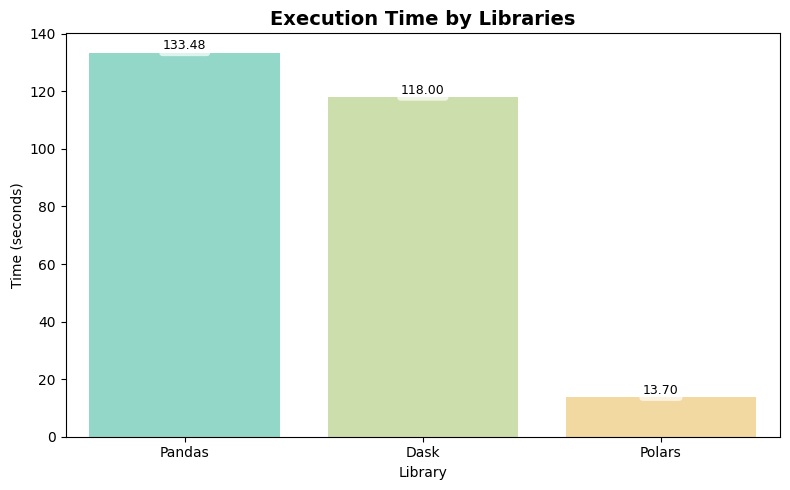

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

execution_times = {
    "Pandas": pandas_elapsed_time,
    "Dask": dask_elapsed_time,
    "Polars": polars_elapsed_time
}

# Create DataFrame for execution time
df_exec = pd.DataFrame.from_dict(execution_times, orient='index', columns=['Execution Time (s)'])
df_exec.reset_index(inplace=True)
df_exec.rename(columns={'index': 'Library'}, inplace=True)

# Plot execution time
plt.figure(figsize=(8, 5))
palette_exec = ['#86e3ce', '#d0e6a5', '#ffdd94']
bars = sns.barplot(data=df_exec, x='Library', y='Execution Time (s)', hue='Library', palette=palette_exec, legend=False)

# Add labels on top of bars
for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.05,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.7)
    )

plt.title("Execution Time by Libraries", fontsize=14, fontweight='bold')
plt.ylabel("Time (seconds)")
plt.xlabel("Library")
plt.tight_layout()
plt.savefig("execution_time_summary.png", dpi=100)
plt.show()

**Compares memory usage of Pandas, Dask, and Polars**

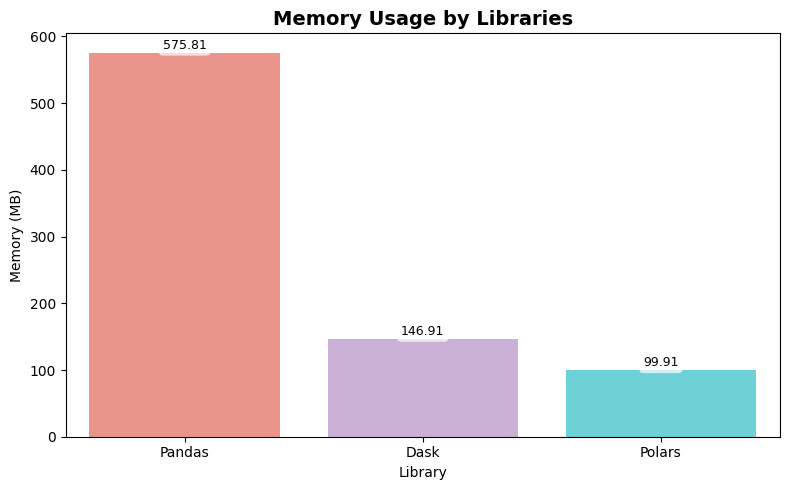

In [ ]:
memory_usages = {
    "Pandas": pandas_memory_used_mb,
    "Dask": dask_memory_used_mb,
    "Polars": polars_memory_used_mb
}

# Create DataFrame for memory usage
df_mem = pd.DataFrame.from_dict(memory_usages, orient='index', columns=['Memory Usage (MB)'])
df_mem.reset_index(inplace=True)
df_mem.rename(columns={'index': 'Library'}, inplace=True)

# Plot memory usage
plt.figure(figsize=(8, 5))
palette_mem = ['#fa897b', '#ccabdb', '#5ce1e6']
bars = sns.barplot(data=df_mem, x='Library', y='Memory Usage (MB)', hue='Library', palette=palette_mem, legend=False)

# Add labels on top of bars
for bar in bars.patches:
    height = bar.get_height()
    bars.text(
        bar.get_x() + bar.get_width() / 2,
        height + 1,
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=9,
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3', alpha=0.7)
    )

plt.title("Memory Usage by Libraries", fontsize=14, fontweight='bold')
plt.ylabel("Memory (MB)")
plt.xlabel("Library")
plt.tight_layout()
plt.savefig("memory_usage_summary.png", dpi=100)
plt.show()